In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy.stats import multivariate_normal
from matplotlib.pyplot import imread

# 1.Gaussian Process for Regression

In [70]:
x = pd.read_csv('gp_x.csv',header=None).to_numpy()
y = pd.read_csv('gp_t.csv',header=None).values

In [71]:
x_train = x[:50,:]
y_train = y[:50,:]
x_test = x[50:,:]
y_test = y[50:,:]

In [72]:
theta = [[0,0,0,1],[1,16,0,0],[1,16,0,4],[1,64,32,0]]
x_pre = np.linspace(0,1,200)

In [73]:
def distance(x): #計算用在kernel裡Xn-Xm的部分
    distance = x.reshape(1,len(x))
    distance = x[0] - distance
    for i in range(len(x)-1):
        temp = x.reshape(1,len(x))
        temp = x[i+1] - temp  
        distance = np.concatenate((distance,temp),axis=0)
    return distance

def kernal(x): #計算用在kernel裡XnTXm的部分
    kernal = x.reshape(1,len(x))
    kernal = x[0] * kernal
    for i in range(len(x)-1):
        temp = x.reshape(1,len(x))
        temp = x[i+1] * temp  
        kernal = np.concatenate((kernal,temp),axis=0)
    return kernal

def cinv(x,param,beta_inv): #計算平均值、標準差都會使用到的Cn inverse
    return np.linalg.inv((param[0]*np.exp(-0.5*param[1]*distance(x)**2)+param[2]+param[3]*kernal(x)+beta_inv*np.eye(len(x))))

def prediction(x,t,x_pre,c_inv,param,beta_inv):
    mean = np.zeros(len(x_pre))
    std1 = np.zeros(len(x_pre))
    std2 = np.zeros(len(x_pre))
    for i in range(len(x_pre)):
        k = param[0]*np.exp(-0.5*param[1]*((x-x_pre[i])**2))+param[2]+param[3]*x*x_pre[i] #k c都是參考手稿裡的公式
        c = param[0]*np.exp(-0.5*param[1]*((x_pre[i]-x_pre[i])**2))+param[2]+param[3]*x_pre[i]*x_pre[i]+beta_inv
        std = np.sqrt(c-np.dot(np.dot(k.T,c_inv),k))
        m = np.dot(np.dot(k.T,c_inv),t)
        mean[i] = m
        std1[i] = m+std
        std2[i] = m-std
    return mean,std1,std2

def plot(x,y,x_pre,mean,std1,std2,param):
    plt.fill_between(x_pre, std1, std2, facecolor='pink')
    plt.plot(x_pre,mean,'r-')
    plt.scatter(x,y,edgecolors='b')
    plt.title(str(param))
    plt.show()
    
def RMS(x_train,y_train,x_test,y_test,c_inv,param):
    train = np.zeros(len(x_train))
    test = np.zeros(len(x_test))
    for i in range(len(x_train)):
        k = param[0]*np.exp(-0.5*param[1]*((x_train-x_train[i])**2))+param[2]+param[3]*x_train*x_train[i]
        train[i] =  np.dot(np.dot(k.T,c_inv),y_train)
    for j in range(len(x_test)):
        k = param[0]*np.exp(-0.5*param[1]*((x_train-x_test[j])**2))+param[2]+param[3]*x_train*x_test[j]
        test[j] = np.dot(np.dot(k.T,c_inv),y_train)
    train = train.reshape(len(train),1)
    test = test.reshape(len(test),1)
    train_error = np.sqrt(np.sum((train-y_train)**2)/len(train))
    test_error = np.sqrt(np.sum((test-y_test)**2)/len(test))
    print(str(param))
    print('Training RMSE = {}'.format(train_error))
    print('Testing RMSE = {}'.format(test_error))

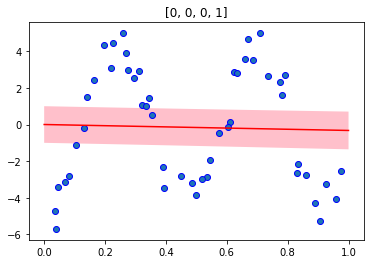

[0, 0, 0, 1]
Training RMSE = 3.1292014298222437
Testing RMSE = 3.3443986601861146


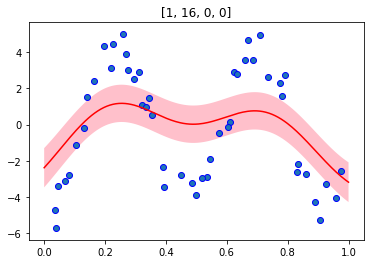

[1, 16, 0, 0]
Training RMSE = 2.4239279278312194
Testing RMSE = 2.668051750252446


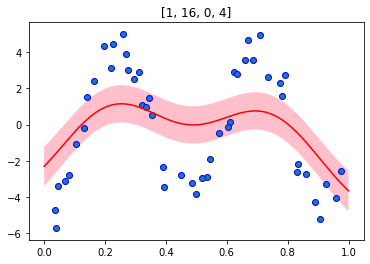

[1, 16, 0, 4]
Training RMSE = 2.4105764871252053
Testing RMSE = 2.656998000166914


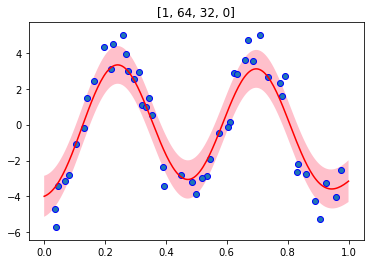

[1, 64, 32, 0]
Training RMSE = 1.0428861621832162
Testing RMSE = 1.1627590936118706


In [74]:
for i in range(4):
    c = cinv(x_train,theta[i],1)
    mean,std1,std2 = prediction(x_train,y_train,x_pre,c,theta[i],1)
    plot(x_train,y_train,x_pre,mean,std1,std2,theta[i])
    RMS(x_train,y_train,x_test,y_test,c,theta[i])

### trial and error部分

In [75]:
theta_test = [[64,64,64,64],[64,64,64,0],[1,64,64,0],[128,128,128,0],[256,256,256,0]]

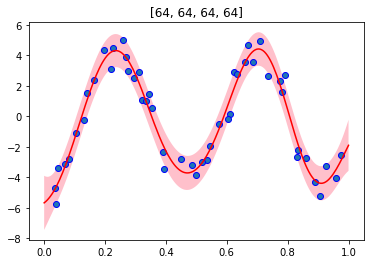

[64, 64, 64, 64]
Training RMSE = 0.6989589734393324
Testing RMSE = 1.0781207291422465


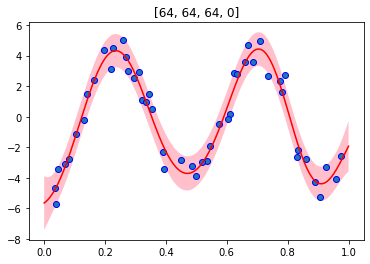

[64, 64, 64, 0]
Training RMSE = 0.6990244741065749
Testing RMSE = 1.0767940009808907


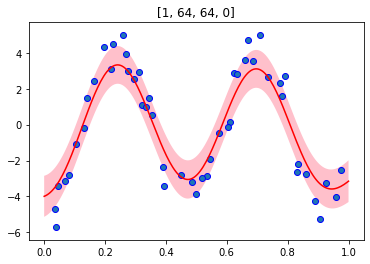

[1, 64, 64, 0]
Training RMSE = 1.04284780556101
Testing RMSE = 1.1627508808212288


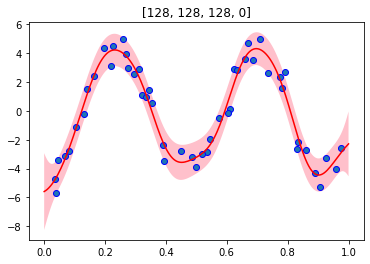

[128, 128, 128, 0]
Training RMSE = 0.673986471256165
Testing RMSE = 1.0766155982289267


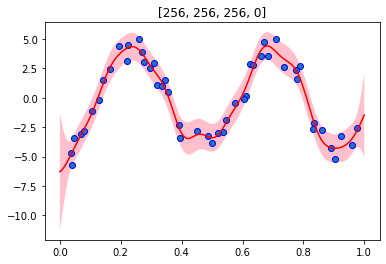

[256, 256, 256, 0]
Training RMSE = 0.6134021619718667
Testing RMSE = 1.1896476361416404


In [76]:
for i in range(len(theta_test)):
    c_test = cinv(x_train,theta_test[i],1)
    mean_test,std1_test,std2_test = prediction(x_train,y_train,x_pre,c_test,theta_test[i],1)
    plot(x_train,y_train,x_pre,mean_test,std1_test,std2_test,theta_test[i])
    RMS(x_train,y_train,x_test,y_test,c_test,theta_test[i])

# 2.Support Vector Machine

In [77]:
x_svm = pd.read_csv('x_train.csv', header=None).to_numpy()
y_svm = pd.read_csv('t_train.csv', header=None).iloc[:, 0].values

In [78]:
def pca(x,n=2): #上次作業做過的PCA，選出最具代表性的特徵向量
    x = x - np.mean(x,axis=0)
    cov_Mat = np.cov(x,rowvar=False)
    val,vec = np.linalg.eig(cov_Mat)   
    sort_index = np.argsort(val)[::-1]
    n_eigenvec = vec[:,sort_index[:n]]
    T1 = x.dot(n_eigenvec)
    T1 = (T1-T1.mean())/T1.std()
    return T1.real


def most_frequent(List): 
    return max(set(List), key = List.count)


def prediction(x,b_dict,w_dict,class_dict):
    result = []
    for i in range(len(x)):
        classify = []
        for j in range(3):
            w = w_dict[j]
            b = b_dict[j]
            y_predict = w.dot(x[i].T)+b
            if y_predict > 0: #計算資料在哪一類取得的分數較高，就歸為該類
                classify.append(class_dict[j][0])
            else:
                classify.append(class_dict[j][1])
        result.append(most_frequent(classify)) 
    return result

def plot_data(xx,yy,b_dict,w_dict,class_dict):
    res = np.zeros(xx.shape)
    for i in range(len(xx)):
        x_t = np.column_stack((xx[0],yy[i]))
        temp = prediction(x_t,b_dict,w_dict,class_dict)
        temp2 = np.array([temp])
        res[i,:] = temp2
    return res

def poly(x_train):
    x0 = (x_train[:,0]**2).reshape(x_train[:,0].shape[0],1)
    x1 = (x_train[:,0]*x_train[:,1]*np.sqrt(2)).reshape(x_train[:,0].shape[0],1)
    x2 = (x_train[:,1]**2).reshape(x_train[:,0].shape[0],1)
    x_poly = np.concatenate((x0,x1,x2),axis=1)
    return x_poly

def plot_data_poly(xx,yy,b_dict,w_dict,class_dict):
    res = np.zeros(xx.shape)
    for i in range(len(xx)):
        x_t = np.column_stack((xx[0],yy[i]))
        temp = prediction(poly(x_t),b_dict,w_dict,class_dict)
        temp2 = np.array([temp])
        res[i,:] = temp2
    return res

In [79]:
x_train = pca(x_svm,2)
target = np.concatenate((np.ones([100,1]),-1*np.ones([100,1]))) #目標tn，值不是1就是-1

# linear kernel

In [80]:
clf = SVC(kernel='linear', C=1, decision_function_shape='ovo') #選用one versus one來訓練
model = clf.fit(x_train,y_svm)
coef = model.dual_coef_.T #dual_coef會算出係數a，並還帶有正負號，之後要再乘上對應target確保值為正
supvec = np.zeros([x_train.shape[0],2])
supvec[model.support_] = coef #紀錄support vector的係數
supvec = abs(supvec)

In [81]:
#由於SVM是進行二元分類，我們有三類便要分三次各自討論
c0 = np.concatenate((supvec[:100,0],-1*supvec[100:200,0])) #這裡做的是將三類倆倆討論，並乘上對應target
c1 = np.concatenate((supvec[:100,1],-1*supvec[200:300,0]))
c2 = np.concatenate((supvec[100:200,1],-1*supvec[200:300,1]))

In [82]:
x0 = x_train[:200,:] #取出各類別的x值
x1 = np.concatenate((x_train[:100,:],x_train[200:300,:]))
x2 = x_train[100:,:]

In [83]:
w0 = c0.dot(x0) #根據手稿公式，計算對應w值
w1 = c1.dot(x1)
w2 = c2.dot(x2)

In [84]:
supvec_group0 = np.nonzero(c0)[0] #找出各類別對應的support vector
supvec_group1 = np.nonzero(c1)[0]
supvec_group2 = np.nonzero(c2)[0]

In [85]:
b0 = np.mean(target[supvec_group0]-x0[supvec_group0].dot(x0[supvec_group0].T).dot(c0[supvec_group0])) #計算各類別的b
b1 = np.mean(target[supvec_group1]-x1[supvec_group1].dot(x1[supvec_group1].T).dot(c1[supvec_group1]))
b2 = np.mean(target[supvec_group2]-x2[supvec_group2].dot(x2[supvec_group2].T).dot(c2[supvec_group2]))

In [86]:
b_dict = {0:b0,1:b1,2:b2}
w_dict = {0:w0,1:w1,2:w2}
class_dict = {0:[0,1],1:[0,2],2:[1,2]}

### plot

In [87]:
x1_min = x_train[:,0].min()
x1_max = x_train[:,0].max()
x2_min = x_train[:,1].min()
x2_max = x_train[:,1].max()
xx,yy = np.meshgrid(np.linspace(x1_min-0.5,x1_max+0.5,1000),np.linspace(x2_min-0.5,x2_max+0.5,1000))
res = plot_data(xx,yy,b_dict,w_dict,class_dict)

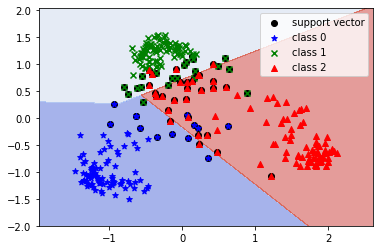

In [88]:
g0 = np.where(y_svm==0)
g1 = np.where(y_svm==1)
g2 = np.where(y_svm==2)
plt.contourf(xx, yy, res, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(x_train[model.support_, 0], x_train[model.support_, 1],c='black', marker="o",label="support vector")
plt.scatter(x_train[g0][:, 0], x_train[g0][:, 1], c='b', marker='*', label="class 0")
plt.scatter(x_train[g1][:, 0], x_train[g1][:, 1], c='g', marker='x', label="class 1")
plt.scatter(x_train[g2][:, 0], x_train[g2][:, 1], c='r', marker='^', label="class 2")
plt.legend()
plt.show()

# polynomial kernel

In [89]:
x_poly = poly(x_train) #作法跟上題差不多，差別是代入的基底為多項式函數

In [90]:
clf_poly = SVC(kernel='poly', C=1,degree = 2, decision_function_shape='ovo')
model_poly = clf.fit(x_poly,y_svm)
coef_poly = model_poly.dual_coef_.T
supvec_poly = np.zeros([x_poly.shape[0],2])
supvec_poly[model_poly.support_] = coef_poly
supvec_poly = abs(supvec_poly)

In [91]:
c0_poly = np.concatenate((supvec_poly[:100,0],-1*supvec_poly[100:200,0]))
c1_poly = np.concatenate((supvec_poly[:100,1],-1*supvec_poly[200:300,0]))
c2_poly = np.concatenate((supvec_poly[100:200,1],-1*supvec_poly[200:300,1]))

In [92]:
x0_poly = x_poly[:200,:]
x1_poly = np.concatenate((x_poly[:100,:],x_poly[200:300,:]))
x2_poly = x_poly[100:,:]

In [93]:
w0_poly = c0_poly.dot(x0_poly)
w1_poly = c1_poly.dot(x1_poly)
w2_poly = c2_poly.dot(x2_poly)

In [94]:
m0 = np.where(((c0_poly>0) & (c0_poly<1)))[0] #和上題不同的地方還有須考慮box constraints
m1 = np.where(((c1_poly>0) & (c1_poly<1)))[0]
m2 = np.where(((c2_poly>0) & (c2_poly<1)))[0]
s0 = np.nonzero(c0_poly)[0]
s1 = np.nonzero(c1_poly)[0]
s2 = np.nonzero(c2_poly)[0]

In [95]:
b0_poly = np.mean(target[m0]-x0_poly[m0].dot(x0_poly[s0].T).dot(c0_poly[s0]))
b1_poly = np.mean(target[m1]-x1_poly[m1].dot(x1_poly[s1].T).dot(c1_poly[s1]))
b2_poly = np.mean(target[m2]-x2_poly[m2].dot(x2_poly[s2].T).dot(c2_poly[s2]))

In [96]:
b_dict_p = {0:b0_poly,1:b1_poly,2:b2_poly}
w_dict_p = {0:w0_poly,1:w1_poly,2:w2_poly}
class_dict_p = {0:[0,1],1:[0,2],2:[1,2]}

### plot

In [97]:
x1_min = x_train[:,0].min()
x1_max = x_train[:,0].max()
x2_min = x_train[:,1].min()
x2_max = x_train[:,1].max()
xx,yy = np.meshgrid(np.linspace(x1_min-0.5,x1_max+0.5,1000),np.linspace(x2_min-0.5,x2_max+0.5,1000))
res_poly = plot_data_poly(xx,yy,b_dict_p,w_dict_p,class_dict_p)

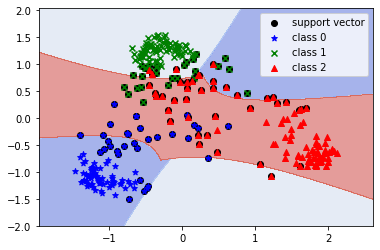

In [98]:
g0 = np.where(y_svm==0)
g1 = np.where(y_svm==1)
g2 = np.where(y_svm==2)
plt.contourf(xx, yy, res_poly, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(x_train[model_poly.support_, 0], x_train[model_poly.support_, 1],c='black', marker="o",label="support vector")
plt.scatter(x_train[g0][:, 0], x_train[g0][:, 1], c='b', marker='*', label="class 0")
plt.scatter(x_train[g1][:, 0], x_train[g1][:, 1], c='g', marker='x', label="class 1")
plt.scatter(x_train[g2][:, 0], x_train[g2][:, 1], c='r', marker='^', label="class 2")
plt.legend()
plt.show()

# 3.Gaussian Mixture Model

In [99]:
img = imread('imghw3.jpg')
img = img.reshape(76480,3)/255 #normalization

In [100]:
def Kmean(img,K,iterations):
    r = np.eye(K)
    mu = img[np.random.randint(0,high=len(img),size=K)] #設定初始的K類平均值以及rnk
    rnk = np.zeros([76480,K])
    for j in range(iterations):
        rnk_pre = rnk
        dist = img.reshape(76480,1,3) - mu #根據手稿公式，先找出各資料歸在何類，再更新平均值
        sqr = np.sum(dist**2,axis=2)
        class_k = np.argmin(sqr,axis=1)
        rnk = r[class_k]
        if np.array_equal(rnk,rnk_pre):
            break
        else:
            mu = np.sum(rnk.reshape(76480,K,1)*img.reshape(76480,1,3),axis=0)/np.sum(rnk,axis=0).reshape(K,1)  
    mu = (mu*255).astype(int)
    dic = {'R':mu[:,0],'G':mu[:,1],'B':mu[:,2]}
    print('K-means K={}'.format(K))
    print(pd.DataFrame.from_dict(dic),'\n')
    return mu,rnk

def EM(img,mu,rnk,K,iterations):
    log = []
    pi = np.sum(rnk,axis = 0)/len(rnk) #用K-means得到的平均值跟rnk來當EM的初始值
    mu_init = mu/255 
    cov = np.array([np.cov(img[np.where(rnk[:,i]==1)[0]].T) for i in range(len(rnk.T))])
    gau = np.array([multivariate_normal.pdf(img,mu_init[i],cov[i]) for i in range(len(rnk.T))])
    for i in range(iterations):
        # E step 先計算responsibility
        resp = (gau/np.sum(gau,axis=0)).T
        # M step 再逐步更新各數值
        mu_new = np.sum(resp.reshape(76480,K,1)*img.reshape(76480,1,3),axis=0)/np.sum(resp,axis=0).reshape(K,1)
        for j in range(K):
            cov[j] = (resp[:,j,None]*(img-mu_new[j])).T.dot(img-mu_new[j])/np.sum(resp,axis=0)[j]
        pi = np.sum(resp,axis=0)/len(img)
        for k in range(K):
            gau[k] = multivariate_normal.pdf(img,mu_new[k],cov[k])*pi[k]
        log_likelihood = np.sum(np.log(np.sum(gau,axis=0))) #計算log likelihood值
        log.append(log_likelihood)
    mu_new = (mu_new*255).astype(int)
    dic = {'R':mu_new[:,0],'G':mu_new[:,1],'B':mu_new[:,2]}
    print('GMM K={}'.format(K))
    print(pd.DataFrame.from_dict(dic),'\n')
    return log,mu_new,gau

def plot_log(log,K):
    plt.title('GMM Log likelihood K = {}'.format(K))
    plt.plot(log)
    plt.show()

def K_means_img(mu,rnk,K):
    data = (mu[np.argmax(rnk.T, axis=0)]).astype(int)
    plt.title('image K-means K = {}'.format(K))
    plt.imshow(data.reshape(239,320,3))
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
def K_GMM_img(mu,gau,K):
    data = (mu[np.argmax(gau, axis=0)]).astype(int)
    plt.title('image GMM K = {}'.format(K))
    plt.imshow(data.reshape(239,320,3))
    plt.xticks(())
    plt.yticks(())
    plt.show()

K-means K=3
     R    G    B
0  133  126  104
1   73   66   52
2  194  195  182 

GMM K=3
     R    G    B
0  137  125   87
1   80   67   58
2  128  131  124 



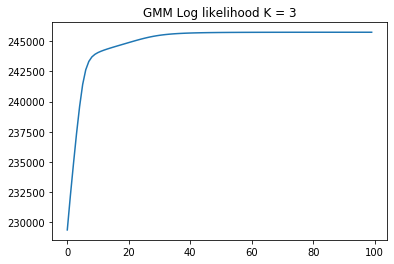

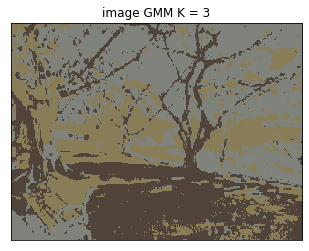

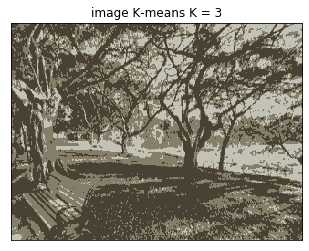



K-means K=5
     R    G    B
0  133  125  103
1   59   52   39
2   93   86   69
3  214  217  210
4  169  168  148 

GMM K=5
     R    G    B
0  126  111   85
1   79   65   58
2   74   71   60
3  160  165  165
4  141  151  112 



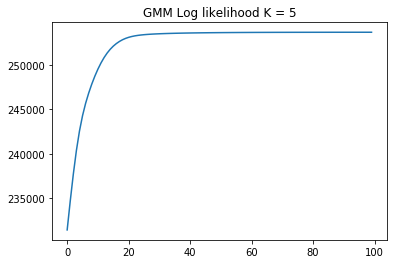

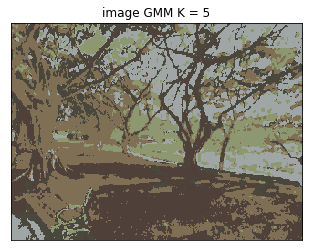

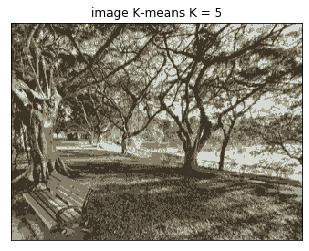



K-means K=7
     R    G    B
0  110  102   82
1  139  132  113
2  188  174  122
3  219  222  216
4  163  173  173
5   51   44   32
6   80   72   59 

GMM K=7
     R    G    B
0  113   97   73
1  151  140  115
2  129  133   79
3  185  190  189
4  127  132  132
5   77   64   57
6   69   65   55 



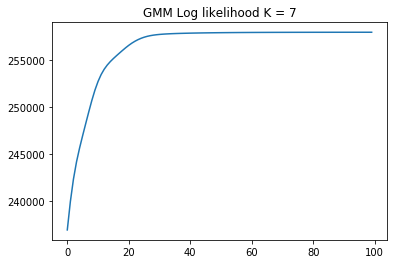

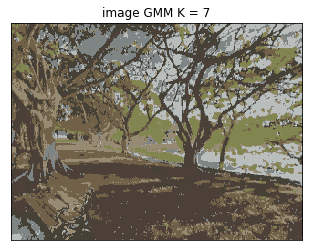

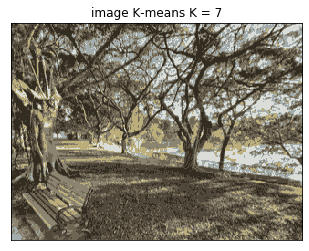



K-means K=10
     R    G    B
0  188  195  192
1  119  108   82
2   70   62   49
3  155  139  103
4  231  233  229
5  151  159  157
6  118  124  122
7  199  184  130
8   44   38   25
9   90   84   69 

GMM K=10
     R    G    B
0  173  179  170
1  126  107   83
2   78   65   58
3  161  147  116
4  227  228  228
5  149  153  151
6  115  121  124
7  126  130   71
8   62   55   35
9   87   84   72 



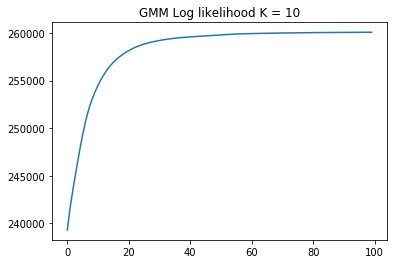

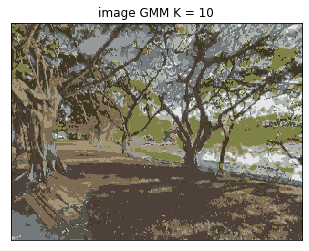

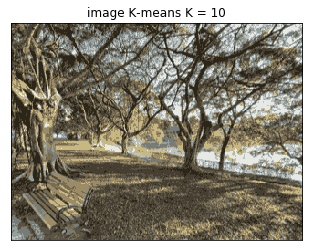

In [101]:
K = [3,5,7,10]
for i in K:
    mu,rnk = Kmean(img,i,300)
    log,mu_new,gau = EM(img,mu,rnk,i,100)
    plot_log(log,i)
    K_GMM_img(mu_new,gau,i)
    K_means_img(mu,rnk,i)
    print('\n')